In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from matplotlib import animation
import matplotlib as mpl
from IPython.display import HTML, display

torch.cuda.empty_cache()


# Figure out whether to use cpu or cuda.
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using mps')
else:
    device = torch.device('cpu')
    print('Using cpu')

Using cuda


In [2]:
data_file = xr.open_dataset("./data/sst.mnmean.nc")
mask_file = xr.open_dataset("./data/lsmask.nc")

In [3]:
lat = torch.as_tensor(data_file.lat.to_numpy())
sst = torch.as_tensor(data_file.sst.to_numpy())
lon = torch.as_tensor(data_file.lon.to_numpy())
mask = torch.as_tensor(mask_file.mask.to_numpy().astype(bool)[0])

In [4]:
sst_masked = sst[:, mask]
sst_masked = (sst[:, mask] - torch.mean(sst[:, mask], axis=0, keepdims=True)).to(device)

In [5]:
sst_train       = sst_masked[0:int(sst_masked.shape[0]*0.8)]
sst_validate    = sst_masked[int(sst_masked.shape[0]*0.8):int(sst_masked.shape[0]*0.9)]
sst_test        = sst_masked[int(sst_masked.shape[0]*0.9):]

# SVD

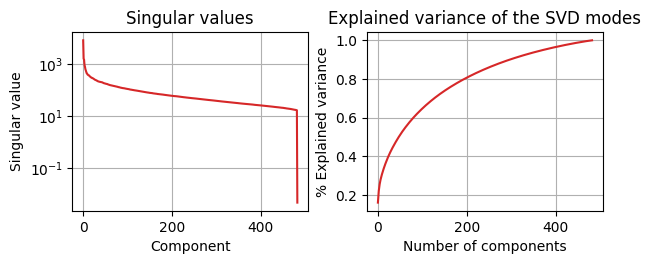

In [39]:
U, sigma, Vt = torch.linalg.svd(sst_masked.T, full_matrices=False)

fig, axs = plt.subplots(1,2,figsize=(6,2.5), constrained_layout=True)
axs[0].semilogy(sigma.cpu(), color="tab:red")
axs[0].set_title("Singular values")
axs[0].set_xlabel("Component")
axs[0].set_ylabel("Singular value")
axs[0].grid()

axs[1].plot((torch.cumsum(sigma, dim=0) / torch.sum(sigma)).cpu(), color="tab:red")
axs[1].set_title("Explained variance of the SVD modes")
axs[1].set_xlabel("Number of components")
axs[1].set_ylabel("% Explained variance")
axs[1].grid()


plt.savefig("svd_analysis.svg", bbox_inches='tight', dpi=300)

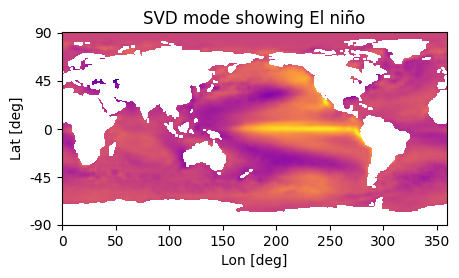

In [7]:
res = np.zeros(mask.shape)*np.nan
res[mask] = U[:,3].cpu()
plt.figure(figsize=(6,2.5))
plt.imshow(res, cmap="plasma")
plt.xlabel("Lon [deg]")
plt.ylabel("Lat [deg]")
plt.title("SVD mode showing El niño")
plt.yticks([0, 45, 90, 135, 179.5],[90, 45, 0, -45, -90])
plt.savefig("svd_el_nino.svg", dpi=300)

# Autoencoder

In [8]:
import torch.jit as jit

class AE(jit.ScriptModule):
    def __init__(self, latent_size=500):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(sst_masked.shape[1], 1_000),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(1_000, latent_size),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_size, 1_000),
            torch.nn.ReLU(),
            torch.nn.Linear(1_000, sst_masked.shape[1]),
        )
    
    @jit.script_method
    def forward(self, x):
        y = self.encoder(x)
        x_bar = self.decoder(y)
        return x_bar
    
    @jit.script_method
    def encode(self,x):
        return self.encoder(x)
    
    @jit.script_method
    def decode(self, y):
        return self.decoder(y)


In [9]:
torch.cuda.empty_cache()

sst_masked = sst_masked.to(device)
model = AE().to(device)
loss_fn = nn.MSELoss()
losses_train = []
losses_train_validation = []

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for i in range(1000):
    pred_train = model.forward(sst_train)
    loss_train = loss_fn(pred_train, sst_train)
    losses_train.append(loss_train.item())

    model.eval()
    pred_validate = model.forward(sst_validate)
    loss_validate = loss_fn(pred_validate, sst_validate)
    losses_train_validation.append(loss_validate.item())
    model.train()

    loss_train.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch: {i}\t Train loss: {loss_train.item()} \t Validation loss: {loss_validate.item()}")

Epoch: 0	 Train loss: 3.522411346435547 	 Validation loss: 3.8235745429992676
Epoch: 1	 Train loss: 3.9993298053741455 	 Validation loss: 4.315732002258301
Epoch: 2	 Train loss: 3.609010934829712 	 Validation loss: 3.8998007774353027
Epoch: 3	 Train loss: 3.5791563987731934 	 Validation loss: 3.870595932006836
Epoch: 4	 Train loss: 3.570627450942993 	 Validation loss: 3.864503860473633
Epoch: 5	 Train loss: 3.5103750228881836 	 Validation loss: 3.7975380420684814
Epoch: 6	 Train loss: 3.4160683155059814 	 Validation loss: 3.6909284591674805
Epoch: 7	 Train loss: 3.3230950832366943 	 Validation loss: 3.5877511501312256
Epoch: 8	 Train loss: 3.225017786026001 	 Validation loss: 3.4806551933288574
Epoch: 9	 Train loss: 3.112173557281494 	 Validation loss: 3.3586668968200684
Epoch: 10	 Train loss: 2.9886598587036133 	 Validation loss: 3.221597909927368
Epoch: 11	 Train loss: 2.851137399673462 	 Validation loss: 3.072103261947632
Epoch: 12	 Train loss: 2.706775665283203 	 Validation loss: 2

In [11]:
latent_sizeses = torch.arange(100, 2000, 50)
last_train_loss = []
last_validation_loss = []
for latent_size in latent_sizeses:
    model_step = AE(latent_size=int(latent_size)).to(device)
    optimizer = torch.optim.Adam(model_step.parameters(), lr=0.0001)
    for i in range(1000):
        pred_train = model_step.forward(sst_train)
        loss_train = loss_fn(pred_train, sst_train)

        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()

    model_step.eval()
    pred_train = model_step.forward(sst_train)
    pred_validate = model_step.forward(sst_validate)

    loss_train = loss_fn(pred_train, sst_train)
    loss_validate = loss_fn(pred_validate, sst_validate)

    last_train_loss.append(loss_train.item())
    last_validation_loss.append(loss_validate.item())
    print(f"Latent size: {latent_size}\t Test loss: {loss_train.item()}\t Validation loss: {loss_validate.item()}")


Latent size: 100	 Test loss: 0.1282949000597	 Validation loss: 0.30655738711357117
Latent size: 150	 Test loss: 0.12039323896169662	 Validation loss: 0.2938448190689087
Latent size: 200	 Test loss: 0.11976176500320435	 Validation loss: 0.31533142924308777
Latent size: 250	 Test loss: 0.12246078252792358	 Validation loss: 0.28412824869155884
Latent size: 300	 Test loss: 0.11658838391304016	 Validation loss: 0.2973364591598511
Latent size: 350	 Test loss: 0.11269751936197281	 Validation loss: 0.2816413342952728
Latent size: 400	 Test loss: 0.11406008154153824	 Validation loss: 0.27652907371520996
Latent size: 450	 Test loss: 0.11106537282466888	 Validation loss: 0.27414798736572266
Latent size: 500	 Test loss: 0.10845563560724258	 Validation loss: 0.2852330207824707
Latent size: 550	 Test loss: 0.10861345380544662	 Validation loss: 0.27602264285087585
Latent size: 600	 Test loss: 0.10624264925718307	 Validation loss: 0.2769205570220947
Latent size: 650	 Test loss: 0.11220643669366837	 Va

# Validate model

In [12]:
model.eval()
sst_train_encoded = model.encode(sst_train).detach()
A = sst_train_encoded.T[:,1:] @ torch.pinverse(sst_train_encoded.T[:,0:-1])

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0000001)
losses_validate = []
losses_validate_test = []

In [14]:
epochs_validate = 10_000


for i in range(epochs_validate):
    
    sst_validate_encoded = model.encode(sst_validate)
    sst_validate_encoded_pred = A @ sst_validate_encoded.T[:,0:-1]
    sst_validate_decoded_pred = model.decode(sst_validate_encoded_pred.T)

    loss_validate = loss_fn(sst_validate_decoded_pred, sst_validate[1:])
    losses_validate.append(loss_validate.item())

    sst_test_encoded = model.encode(sst_test)
    sst_test_encoded_pred = A @ sst_test_encoded.T[:,0:-1]
    sst_test_decoded_pred = model.decode(sst_test_encoded_pred.T)

    loss_validate_test = loss_fn(sst_test_decoded_pred, sst_test[1:])
    losses_validate_test.append(loss_validate_test.item())

    loss_validate.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Epoch: {i}\t Validate loss: {loss_validate.item()} \t Test loss: {loss_validate_test.item()}")

Epoch: 0	 Validate loss: 0.6197622418403625 	 Test loss: 0.5444499850273132
Epoch: 1	 Validate loss: 0.6196845173835754 	 Test loss: 0.54441899061203
Epoch: 2	 Validate loss: 0.6196066737174988 	 Test loss: 0.5443879961967468
Epoch: 3	 Validate loss: 0.6195290088653564 	 Test loss: 0.5443570017814636
Epoch: 4	 Validate loss: 0.6194512844085693 	 Test loss: 0.54432612657547
Epoch: 5	 Validate loss: 0.6193737983703613 	 Test loss: 0.5442952513694763
Epoch: 6	 Validate loss: 0.6192962527275085 	 Test loss: 0.5442643761634827
Epoch: 7	 Validate loss: 0.6192188858985901 	 Test loss: 0.5442335605621338
Epoch: 8	 Validate loss: 0.6191415190696716 	 Test loss: 0.5442026853561401
Epoch: 9	 Validate loss: 0.619064211845398 	 Test loss: 0.5441720485687256
Epoch: 10	 Validate loss: 0.618986964225769 	 Test loss: 0.5441413521766663
Epoch: 11	 Validate loss: 0.6189098954200745 	 Test loss: 0.5441106557846069
Epoch: 12	 Validate loss: 0.6188327074050903 	 Test loss: 0.5440799593925476
Epoch: 13	 Vali

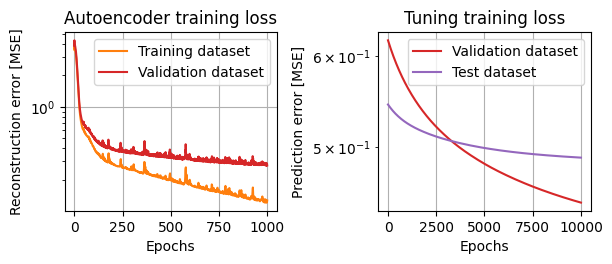

In [15]:
fig,axs = plt.subplots(1,2, figsize=(6,2.5), layout="constrained")
# fig.set_tight_layout(True)

axs[0].semilogy(losses_train, label="Training dataset", color="tab:orange")
axs[0].semilogy(losses_train_validation, label="Validation dataset", color="tab:red")
axs[0].set_title("Autoencoder training loss")
axs[0].set_ylabel("Reconstruction error [MSE]")
axs[0].set_xlabel("Epochs")
axs[0].legend()
axs[0].grid()

axs[1].semilogy(losses_validate, color="tab:red", label="Validation dataset")
axs[1].semilogy(losses_validate_test, color="tab:purple", label="Test dataset")
axs[1].set_title("Tuning training loss")
axs[1].set_ylabel("Prediction error [MSE]")
axs[1].set_xlabel("Epochs")
axs[1].legend()
axs[1].grid()


plt.savefig("model_training_losses.svg", bbox_inches='tight', dpi=300)

# SVD results

In [17]:
svd_train = torch.row_stack((sst_train,sst_validate)).T
svd_test = sst_test.T

U, sigma, Vt = torch.linalg.svd(svd_train, full_matrices=False)

svd_train_encoded = U.T @ svd_train
svd_test_encoded = U.T @ svd_test

A_svd = svd_train_encoded[:,1:] @ torch.pinverse(svd_train_encoded[:,0:-1])

svd_test_predicted_encoded = torch.stack([(torch.matrix_power(A_svd, i) @ svd_test_encoded[:,0]).detach() for i in range(svd_test_encoded.shape[1])])
svd_test_predicted = U @ svd_test_predicted_encoded.T
svd_test_error = (svd_test_predicted - svd_test).T.cpu()

# Autoencoder results

In [18]:
model.eval()

sst_test_encoded = model.encode(sst_test[0])
sst_test_predicted_encoded = torch.stack([(torch.matrix_power(A, i) @ sst_test_encoded).detach() for i in range(sst_test.shape[0])])
sst_test_predicted = model.decoder(sst_test_predicted_encoded).detach()
sst_test_error = (sst_test_predicted - sst_test)


sst_test_predicted = sst_test_predicted.cpu()
sst_test_error = sst_test_error.cpu()

# Show results

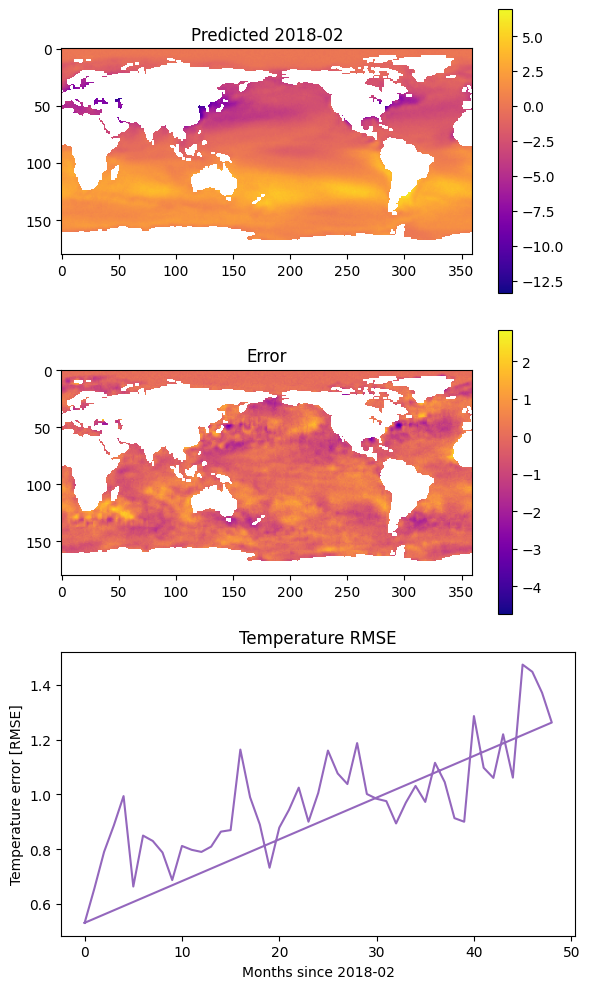

In [49]:
fig, axs = plt.subplots(3,1, figsize=(6,10))
fig.set_tight_layout(True)

mat_show = torch.zeros((sst.shape[1], sst.shape[2]))*np.nan
dates = np.datetime_as_string(data_file.time.data[int(sst_masked.shape[0]*0.9):], "M")

mat_show[mask] = sst_test_predicted[0]
pl1 = axs[0].imshow(mat_show, cmap="plasma")
mat_show[mask] = sst_test_error[0]
pl2 = axs[1].imshow(mat_show, cmap="plasma")


x_data = []
y_data = []

plt.colorbar(pl1, ax=axs[0])
plt.colorbar(pl2, ax=axs[1])

def animate(i):

   mat_show[mask] = sst_test_predicted[i]
   pl1.set_data(mat_show)
   axs[0].set_title(f"Predicted {dates[i]}")

   mat_show[mask] = sst_test_error[i]
   pl2.set_data(mat_show)
   axs[1].set_title(f"Error")

   x_data.append(i)
   y_data.append( torch.sqrt(torch.mean(sst_test_error[i]**2)) )

   axs[2].clear()
   axs[2].plot(x_data, y_data, color="tab:purple")
   axs[2].set_title("Temperature RMSE")
   axs[2].set_xlabel("Months since 2018-02")
   axs[2].set_ylabel("Temperature error [RMSE]")
   

ani = animation.FuncAnimation(fig, animate, frames=sst_test.shape[0])
ani.save("model_predictions.mp4", fps=5)

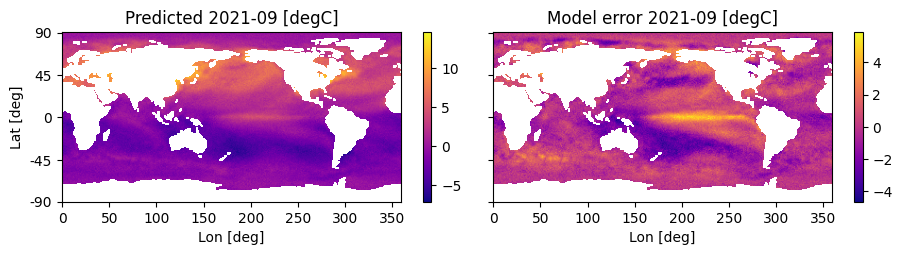

In [45]:
fig, axs = plt.subplots(1,2, figsize=(9.5,2.5), sharey=True, layout="constrained")
fig.set_tight_layout(True)

to_plot = 43
mat_show = torch.zeros((sst.shape[1], sst.shape[2]))*np.nan
dates = np.datetime_as_string(data_file.time.data[int(sst_masked.shape[0]*0.9):], "M")

mat_show[mask] = sst_test_predicted[to_plot]
pl1 = axs[0].imshow(mat_show, cmap="plasma")
axs[0].set_title(f"Predicted {dates[to_plot]} [degC]")
axs[0].set_xlabel("Lon [deg]")
axs[0].set_ylabel("Lat [deg]")
axs[0].set_yticks([0,45, 90, 135, 179.5], [90, 45, 0, -45, -90])

mat_show[mask] = sst_test_error[to_plot]
axs[1].set_xlabel("Lon [deg]")
pl2 = axs[1].imshow(mat_show, cmap="plasma")
axs[1].set_title(f"Model error {dates[to_plot]} [degC]")

plt.colorbar(pl1, ax=axs[0])
plt.colorbar(pl2, ax=axs[1])

plt.savefig("model_el_nino_prediction.svg")


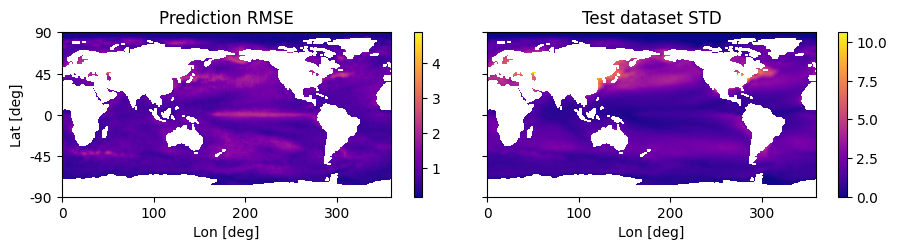

In [47]:
fig, axs = plt.subplots(1,2, figsize=(9.5,2.5), sharey=True, layout="constrained")
fig.set_tight_layout(True)

mat_show = torch.zeros((sst.shape[1], sst.shape[2]))*np.nan
mat_show[mask] = torch.sqrt(torch.mean(sst_test_error**2, axis=0))
pl1 = axs[0].imshow(mat_show, cmap="plasma")
axs[0].set_title("Prediction RMSE")
axs[0].set_xlabel("Lon [deg]")
axs[0].set_ylabel("Lat [deg]")
axs[0].set_yticks([0,45, 90, 135, 179.5], [90, 45, 0, -45, -90])
plt.colorbar(pl1, ax=axs[0])

mat_show[mask] = torch.std(sst_test.cpu(), axis=0)
pl2 = axs[1].imshow(mat_show, cmap="plasma")
plt.colorbar(pl2, ax=axs[1])
axs[1].set_xlabel("Lon [deg]")
axs[1].set_title("Test dataset STD")

plt.savefig("model_evaluation.svg")


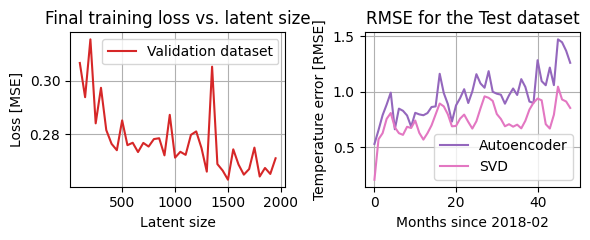

In [46]:
fig, axs = plt.subplots(1,2, figsize=(6,2.5), layout="constrained")
fig.set_tight_layout(True)


# axs[0].plot(latent_sizeses, last_train_loss, color="tab:orange", label="Training dataset")
axs[0].plot(latent_sizeses, last_validation_loss, color="tab:red", label="Validation dataset")
axs[0].set_title("Final training loss vs. latent size")
axs[0].set_xlabel("Latent size")
axs[0].set_ylabel("Loss [MSE]")
axs[0].grid()
axs[0].legend()


axs[1].plot( torch.sqrt(torch.mean(sst_test_error**2, axis=1)), color="tab:purple", label="Autoencoder")
axs[1].plot( torch.sqrt(torch.mean(svd_test_error**2, axis=1)), color="tab:pink", label="SVD")
axs[1].set_title("RMSE for the Test dataset")
axs[1].set_xlabel("Months since 2018-02")
axs[1].set_ylabel("Temperature error [RMSE]")
axs[1].grid()
axs[1].legend()

plt.savefig("model_prediction_error.svg", dpi=300)

# Analyse model

In [ ]:
sst_encoded = model.encode(sst_masked).cpu().detach()
sst_pred = model.forward(sst_masked).cpu().detach()

In [ ]:
plt.plot(sst_encoded[:,0])
plt.xlim(0,12*12)
plt.xlabel("Time [months]")
plt.ylabel("Power of component[0] in latent space")

In [ ]:

fig, axs = plt.subplots(3,1, figsize=(10,10))
fig.set_tight_layout(True)

to_plot = 11

pred_mat = torch.zeros((sst.shape[1], sst.shape[2]))*np.nan
true_mat = torch.zeros((sst.shape[1], sst.shape[2]))*np.nan
pred_mat[mask] = sst_pred[to_plot].cpu()
true_mat[mask] = sst_masked[to_plot].cpu()

axs[0].set_title("Predicted SST")
pl1 = axs[0].matshow(pred_mat.detach())
plt.colorbar(pl1, ax=axs[0])

axs[1].set_title("SST")
pl2 = axs[1].matshow(true_mat.detach())
plt.colorbar(pl2, ax=axs[1])

axs[2].set_title("Difference")
pl3 = axs[2].matshow(torch.abs(pred_mat - true_mat).detach())
plt.colorbar(pl3, ax=axs[2])

In [ ]:
eigens = torch.linalg.eigvals(A.cpu())
plt.scatter(np.real(eigens), np.imag(eigens))
